(autodiff)=

# Automatic differentation & gradient-based inference

In [1]:
import exoplanet

exoplanet.utils.docs_setup()
print(f"exoplanet.__version__ = '{exoplanet.__version__}'")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


exoplanet.__version__ = '0.6.0'


The major selling point of `exoplanet` compared to other similar libraries is that it integrates with the `PyMC` probabilistic modeling framework.
`PyMC` offers gradient-based inference algorithms (more on these below) that can be more computationally efficient (per effective sample) than other tools commonly used for probabilistic inference in astrophysics.
When I am writing this, gradient-based inference methodology is not widely used in astro because it can be difficult to compute the relevant gradients (derivatives of your log probability function with respect to the parameters).
`PyMC` (and many other frameworks like it) handle this issue using [automatic differentiation (AD)](https://en.wikipedia.org/wiki/Automatic_differentiation), a method (or collection of methods) for automatically propagating derivatives through your code.

It's beyond the scope of this tutorial to go into too many details about AD and most users of `exoplanet` shouldn't need to interact with this too much, but this should at least give you a little taste of the kinds of things AD can do for you and demonstrate how this translates into efficient inference with probabilistic models.
The main thing that I want to emphasize here is that AD is not the same as _symbolic differentiation_ (it's not going to provide you with a mathematical expression for your gradients), but it's also not the same as numerical methods like [finite difference](https://en.wikipedia.org/wiki/Finite_difference).
Using AD to evaluate the gradients of your model will generally be faster, more efficient, and more numerically stable than alternatives, but there are always exceptions to any rule.
There are times when providing your AD framework with a custom implementation and/or differentation rule for a particular function is beneficial in terms of cost and stability.
`exoplanet` is designed to provide these custom implementations only where it is useful (e.g. solving Kepler's equation or evaluating limb-darkened light curves) and then rely on the existing AD toolkit elsewhere.

## Automatic differentiation in PyTensor

Let's start by giving a quick taste for how AD works in the context of `PyMC` and `exoplanet`.
`PyMC` is built on top of a library called `PyTensor`, a fork of the now unmaintained Theano library that was designed for AD and fast linear algebra in the context of neural networks.
The learning curve can be steep because your code ends up looking a little different from the usual way you would write Python code.
(If you're looking for something more "Pythonic", [JAX](https://github.com/google/jax) might be a good alternative, but for our purposes, we'll stick with `PyTensor`.)
In `PyTensor`, you start by defining the _relationships_ between variables and then ask to evaluate a variable using this "graph".
This might seem a little counterintuitive, and you hopefully won't have to worry about this too much, but it can be a handy workflow because `PyTensor` will compile and optimize your model in the background (generally making it faster).
This structure allows us to evaluate the derivative of some variable with respect to another.

Here's a simple example where we define a relationship between two variables `x` and `y`:

$$
y = \exp\left[\sin\left(\frac{2\,\pi\,x}{3}\right)\right]
$$

and then calculate the derivative using AD.
For comparison, the symbolic derivative is:

$$
\frac{\mathrm{d}y}{\mathrm{d}x} = \frac{2\,\pi}{3}\,\exp\left[\sin\left(\frac{2\,\pi\,x}{3}\right)\right]\,\cos\left(\frac{2\,\pi\,x}{3}\right)
$$

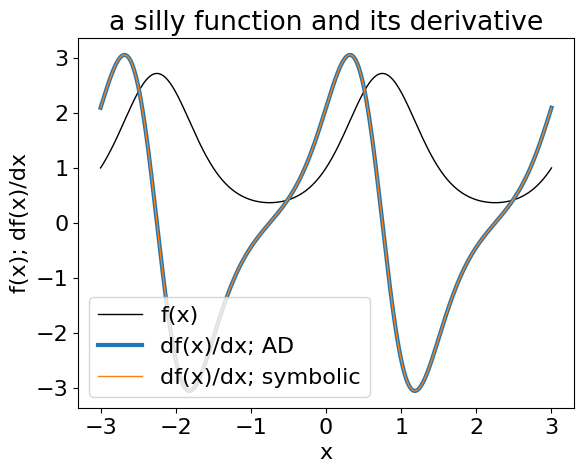

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pytensor
import pytensor.tensor as pt

# Define the relationship between two variables x and y=f(x)
x_ = pt.vector("x")
y_ = pt.exp(pt.sin(2 * np.pi * x_ / 3.0))

# Here pytensor will compile a function to evaluate y
func = pytensor.function([x_], y_)

# Request the gradient of y with respect to x
# Note the call to `sum`. This is a bit of a cheat since by
# default pytensor only computes gradients of a *scalar* function
grad = pytensor.function([x_], pytensor.grad(pt.sum(y_), x_))

# Plot the function and its derivative
x = np.linspace(-3, 3, 500)
plt.plot(x, func(x), "k", lw=1, label="f(x)")
plt.plot(x, grad(x), "C0", label="df(x)/dx; AD", lw=3)

# Overplot the symbolic derivative for comparison
plt.plot(
    x,
    2 * np.pi * func(x) * np.cos(2 * np.pi * x / 3.0) / 3.0,
    "C1",
    lw=1,
    label="df(x)/dx; symbolic",
)

plt.legend()
plt.title("a silly function and its derivative")
plt.ylabel("f(x); df(x)/dx")
_ = plt.xlabel("x")

This example is obviously pretty artificial, but I think that you can imagine how something like this would start to come in handy when your models get more complicated.
In particular, I think that you'll probably pretty regularly find yourself experimenting with different choices of parameters and it would be a real pain to be required to re-write all your derivative code for every new choice of parameterization.

## Gradient-based inference

Now that we have a way of easily evaluating the derivatives of scalar functions, we have a wide array of new inference algorithms at our disposal.
For example, if we use PyTensor to evaluate our log probability function, we could pass the value and gradient to [`scipy.optimize.minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) in order to find the maximum likelihood or maximum a posteriori parameters.
But, the point of `exoplanet` is that it integrates with `PyMC` which provides implementations of various gradient-based Markov chain Monte Carlo (MCMC) methods like [Hamiltonian Monte Carlo](https://en.wikipedia.org/wiki/Hamiltonian_Monte_Carlo) and [No U-Turn Sampling](https://arxiv.org/abs/1111.4246).
`PyMC` also supports gradient-based methods for [variational inference](https://en.wikipedia.org/wiki/Variational_Bayesian_methods), but (so far) `exoplanet` had mostly been used for MCMC.

Take a look at {ref}`intro-to-pymc` for some specific introductory examples of using `PyMC` for MCMC, but the general motivation for using `PyMC` (instead of [emcee](https://emcee.readthedocs.io) or [dynesty](https://dynesty.readthedocs.io), for example) is that it can be far more computationally efficient (per effective sample), especially when your model has more than a couple of parameters.
We're not going to do a systematic study of the relative performance of different methods because that is fraught and can be problem specific, but let's look at another very artificial example where we compare the performance of sampling a 50-dimensional Gaussian using `PyMC` and [`emcee`](https://emcee.readthedocs.io).

In [3]:
import time
import emcee
import logging
import pymc as pm
import arviz as az
import pymc_ext as pmx

logger = logging.getLogger("pymc")
logger.setLevel(logging.ERROR)

# First define and sample the model using PyMC
with pm.Model() as model:
    pm.Normal("x", shape=50)

    # Run a fake chain just to get everything to compile
    pm.sample(
        tune=1, draws=1, chains=1, return_inferencedata=True, progressbar=False
    )

    # Run and time the sampling
    start = time.time()
    pymc_trace = pm.sample(
        tune=1000,
        draws=5000,
        chains=2,
        cores=1,
        return_inferencedata=True,
        progressbar=False,
    )
    pymc_time = time.time() - start

    # Compute the cost per sample
    pymc_per_eff = pymc_time / np.mean(az.summary(pymc_trace)["ess_bulk"])


# Then sample the same model using emcee
func = pmx.utils.Evaluator(model.logp(), model=model)


def logp(theta):
    return func({"x": theta})


ndim = sum([v.size for v in model.initial_point().values()])
init = np.random.randn(124, ndim)
nwalkers, ndim = init.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, logp)

start = time.time()
init = sampler.run_mcmc(init, 1000)
sampler.reset()
sampler.run_mcmc(init, 5000)
emcee_time = time.time() - start

emcee_trace = az.from_emcee(sampler=sampler)
emcee_per_eff = emcee_time / np.mean(az.summary(emcee_trace)["ess_bulk"])

/home/docs/checkouts/readthedocs.org/user_builds/exoplanet/envs/latest/lib/python3.10/site-packages/rich/live.py:23
1: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/docs/checkouts/readthedocs.org/user_builds/exoplanet/envs/latest/lib/python3.10/site-packages/rich/live.py:23
1: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

After running these chains, we can compare the relative performance (remember that this is a very artificial example so caveats, small print, yadda, etc.).
To compare the performance of different MCMC samplers, the best metric is the computational cost per effective sample (for the parameter/function that you most care about).
In this case, we'll look at the total runtime (including burn-in) divided by an estimate of the mean effective sample size across all 50 dimensions (lower is better):

In [4]:
print(
    f"For PyMC, the runtime per effective sample is: {pymc_per_eff * 1e3:.2f} ms"
)
print(
    f"For emcee, the runtime per effective sample is: {emcee_per_eff * 1e3:.2f} ms"
)

For PyMC, the runtime per effective sample is: 0.60 ms
For emcee, the runtime per effective sample is: 50.72 ms


So, in this case, `PyMC` is a few order of magnitude more efficient.
As your models get more complex (in terms of computational cost, number of parameters, and the geometry of your parameter space), your mileage might vary, but my experience is that using `PyMC` is almost always a good idea if you can!

:::{tip}
If you find that your model is not sampling well, this is almost always caused by **parameterization issues** and you'll probably get drastically better performance with some reparameterization.
See {ref}`reparameterization` for some tips and tricks.
:::